In [1]:
import plaidml.keras
plaidml.keras.install_backend()
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [2]:
# Importing useful libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, Flatten, MaxPooling1D
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras import optimizers

import time 

In [3]:
# from google.colab import files
# uploaded = files.upload()

In [4]:
df = pd.read_csv('../data/num_data.csv')

# import io
# df = pd.read_csv(io.BytesIO(uploaded['num_data.csv']))


In [5]:
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    return rmse

### Data Processing

In [6]:
df = pd.read_csv('../data/num_data.csv')

In [7]:
POLLUTION = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

In [8]:
WEATHER = ['PM2.5', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM']

In [9]:
dataset = df

In [10]:
dataset.shape

(420768, 16)

In [11]:
data_size = dataset.shape[0]
train_size=int(data_size * 0.6)
test_size = int(data_size * 0.2)
valid_size = data_size - train_size - test_size

In [12]:
training_set = dataset[:train_size].iloc[:,4:16].values
valid_set = dataset[train_size:train_size+valid_size].iloc[:,4:16].values
test_set = dataset[data_size-test_size:].iloc[:,4:16].values

In [73]:
y = dataset.iloc[:,4].values
y = y.reshape(-1,1)
n_feature = training_set.shape[1]
y.shape

(420768, 1)

In [75]:
# Scaling the dataset
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
valid_set_scaled = sc.fit_transform(valid_set)
test_set_scaled = sc.fit_transform(test_set)

sc_y = MinMaxScaler(feature_range=(0,1))
y_scaled = sc_y.fit_transform(y)

In [76]:
# convert dataset into sequences, where n_steps_in is the input sequence lengith, 
# and n_steps_out is the output sequence length 
def convert_to_sequences(sequences, n_steps_in, n_steps_out):
    X_, y_ = [], []
    for i in range(len(sequences)):
        tail_x = i + n_steps_in
        out_tail_x = tail_x + n_steps_out-1
        if out_tail_x > len(sequences):
            break
        seq_x, seq_y = sequences[i:tail_x, :], sequences[tail_x-1:out_tail_x, 0]
        X_.append(seq_x)
        y_.append(seq_y)
    return np.array(X_), np.array(y_)

In [16]:
n_steps_in = 12
n_steps_out = 12
X_train, y_train = convert_to_sequences(training_set_scaled, n_steps_in, n_steps_out)
X_valid, y_valid = convert_to_sequences(valid_set_scaled, n_steps_in, n_steps_out)
X_test, y_test = convert_to_sequences(test_set_scaled, n_steps_in, n_steps_out)

## Grid Search Control 


In [17]:
n_activation = ['tanh', 'sigmoid', 'relu']
act = n_activation[1]

n_learn_rate = [0.01, 0.001, 0.0001]
lr = n_learn_rate[0]

n_optimizers = [optimizers.Adam(lr=lr), optimizers.RMSprop(lr=lr), optimizers.SGD(lr=lr)]
opt = n_optimizers[0]

n_epoches = [50]
epoch = n_epoches[0]

n_batch_size = [1024, 2048, 5096, 10192]
batch = n_batch_size[-1]

n_of_neurons = [10, 50, 200]
neuron = n_of_neurons[1]

INFO:plaidml:Opening device "llvm_cpu.0"


In [18]:
rmse_df = pd.DataFrame(columns=['Model', 'train_rmse', 'valid_rmse', 'test_rmse', 'train_time', 'epoch', 
                               'batch', 'neuron'])

In [19]:
for batch in n_batch_size:
    for lr in n_learn_rate:
        n_optimizers = [optimizers.Adam(lr=lr)]
        for opt in n_optimizers: 
            for loss_function in ['mean_squared_error', 'mean_absolute_error']:
                CBGRU = Sequential()
                CBGRU.add(Conv1D(filters=64, kernel_size=6, activation='tanh', input_shape=(X_train.shape[1],n_feature)))
                CBGRU.add(MaxPooling1D(pool_size=4))
                CBGRU.add(Dropout(0.2))  
                CBGRU.add(Bidirectional(GRU(units=neuron, return_sequences=False, input_shape=(X_train.shape[1],n_feature), activation=act)))
                CBGRU.add(Dense(units=n_steps_out))
                CBGRU.compile(optimizer=opt,loss=loss_function)


                regressor = CBGRU
                model = 'CBGRU'

                print('training start for', model)    
                start = time.process_time()
                regressor.fit(X_train,y_train,epochs=epoch,batch_size=batch)
                train_time = round(time.process_time() - start, 2)

                print('results for training set')
                y_train_pred = regressor.predict(X_train)
                train_rmse = return_rmse(y_train,y_train_pred)

                print('results for valid set')
                y_valid_pred = regressor.predict(X_valid)
                valid_rmse = return_rmse(y_valid,y_valid_pred)

                print('results for test set')
                y_test_pred = regressor.predict(X_test)
                test_rmse = return_rmse(y_test,y_test_pred)


                one_df = pd.DataFrame([[model, train_rmse, valid_rmse, test_rmse, train_time, batch, lr, loss_function ]],
                              columns=['Model', 'train_rmse', 'valid_rmse', 'test_rmse', 'train_time', 'Batch Size', 
                                   'Learning Rate', 'Loss Function'])
                rmse_df = pd.concat([rmse_df, one_df])

# save the rmse results 
rmse_df.to_csv('../cbgru_grid_search_part3.csv')

            

training start for CBGRU
Epoch 1/50
252438/252438 [==============================] - 20s 78us/step - loss: 0.0047
Epoch 2/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0035
Epoch 3/50
252438/252438 [==============================] - 16s 62us/step - loss: 0.0034
Epoch 4/50
252438/252438 [==============================] - 16s 62us/step - loss: 0.0034
Epoch 5/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0033
Epoch 6/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0033
Epoch 7/50
252438/252438 [==============================] - 16s 63us/step - loss: 0.0033
Epoch 8/50
252438/252438 [==============================] - 16s 62us/step - loss: 0.0032
Epoch 9/50
252438/252438 [==============================] - 16s 63us/step - loss: 0.0032
Epoch 10/50
252438/252438 [==============================] - 16s 62us/step - loss: 0.0032
Epoch 11/50
252438/252438 [==============================] - 16s 62us/step - loss: 0

/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



training start for CBGRU
Epoch 1/50
252438/252438 [==============================] - 20s 80us/step - loss: 0.0592
Epoch 2/50
252438/252438 [==============================] - 15s 61us/step - loss: 0.0394
Epoch 3/50
252438/252438 [==============================] - 16s 63us/step - loss: 0.0385
Epoch 4/50
252438/252438 [==============================] - 16s 62us/step - loss: 0.0381
Epoch 5/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0380
Epoch 6/50
252438/252438 [==============================] - 17s 66us/step - loss: 0.0379
Epoch 7/50
252438/252438 [==============================] - 16s 63us/step - loss: 0.0374
Epoch 8/50
252438/252438 [==============================] - 16s 63us/step - loss: 0.0373
Epoch 9/50
252438/252438 [==============================] - 16s 63us/step - loss: 0.0373
Epoch 10/50
252438/252438 [==============================] - 16s 62us/step - loss: 0.0371
Epoch 11/50
252438/252438 [==============================] - 16s 63us/step - loss: 0

/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



training start for CBGRU
Epoch 1/50
252438/252438 [==============================] - 24s 94us/step - loss: 0.0077
Epoch 2/50
252438/252438 [==============================] - 18s 72us/step - loss: 0.0038
Epoch 3/50
252438/252438 [==============================] - 19s 74us/step - loss: 0.0036
Epoch 4/50
252438/252438 [==============================] - 19s 75us/step - loss: 0.0035
Epoch 5/50
252438/252438 [==============================] - 19s 75us/step - loss: 0.0034
Epoch 6/50
252438/252438 [==============================] - 19s 74us/step - loss: 0.0034
Epoch 7/50
252438/252438 [==============================] - 20s 78us/step - loss: 0.0034
Epoch 8/50
252438/252438 [==============================] - 19s 76us/step - loss: 0.0033
Epoch 9/50
252438/252438 [==============================] - 19s 74us/step - loss: 0.0033
Epoch 10/50
252438/252438 [==============================] - 19s 75us/step - loss: 0.0033
Epoch 11/50
252438/252438 [==============================] - 19s 76us/step - loss: 0

/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



training start for CBGRU
Epoch 1/50
252438/252438 [==============================] - 21s 85us/step - loss: 0.0448
Epoch 2/50
252438/252438 [==============================] - 16s 63us/step - loss: 0.0381
Epoch 3/50
252438/252438 [==============================] - 16s 65us/step - loss: 0.0375
Epoch 4/50
252438/252438 [==============================] - 17s 65us/step - loss: 0.0373
Epoch 5/50
252438/252438 [==============================] - 17s 67us/step - loss: 0.0370
Epoch 6/50
252438/252438 [==============================] - 18s 71us/step - loss: 0.0368
Epoch 7/50
252438/252438 [==============================] - 18s 70us/step - loss: 0.0366
Epoch 8/50
252438/252438 [==============================] - 17s 69us/step - loss: 0.0365
Epoch 9/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0363
Epoch 10/50
252438/252438 [==============================] - 17s 65us/step - loss: 0.0362
Epoch 11/50
252438/252438 [==============================] - 16s 62us/step - loss: 0

/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



training start for CBGRU
Epoch 1/50
252438/252438 [==============================] - 22s 86us/step - loss: 0.0227
Epoch 2/50
252438/252438 [==============================] - 16s 65us/step - loss: 0.0061
Epoch 3/50
252438/252438 [==============================] - 17s 66us/step - loss: 0.0050
Epoch 4/50
252438/252438 [==============================] - 17s 66us/step - loss: 0.0046
Epoch 5/50
252438/252438 [==============================] - 18s 71us/step - loss: 0.0044
Epoch 6/50
252438/252438 [==============================] - 18s 70us/step - loss: 0.0042
Epoch 7/50
252438/252438 [==============================] - 17s 67us/step - loss: 0.0041
Epoch 8/50
252438/252438 [==============================] - 17s 66us/step - loss: 0.0040
Epoch 9/50
252438/252438 [==============================] - 17s 67us/step - loss: 0.0039
Epoch 10/50
252438/252438 [==============================] - 17s 68us/step - loss: 0.0039
Epoch 11/50
252438/252438 [==============================] - 17s 69us/step - loss: 0

/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



training start for CBGRU
Epoch 1/50
252438/252438 [==============================] - 23s 91us/step - loss: 0.0644
Epoch 2/50
252438/252438 [==============================] - 17s 69us/step - loss: 0.0434
Epoch 3/50
252438/252438 [==============================] - 18s 70us/step - loss: 0.0416
Epoch 4/50
252438/252438 [==============================] - 18s 69us/step - loss: 0.0406
Epoch 5/50
252438/252438 [==============================] - 18s 70us/step - loss: 0.0399
Epoch 6/50
252438/252438 [==============================] - 18s 71us/step - loss: 0.0394
Epoch 7/50
252438/252438 [==============================] - 18s 71us/step - loss: 0.0390
Epoch 8/50
252438/252438 [==============================] - 18s 71us/step - loss: 0.0388
Epoch 9/50
252438/252438 [==============================] - 17s 69us/step - loss: 0.0385
Epoch 10/50
252438/252438 [==============================] - 18s 71us/step - loss: 0.0383
Epoch 11/50
252438/252438 [==============================] - 17s 67us/step - loss: 0

/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



training start for CBGRU
Epoch 1/50
252438/252438 [==============================] - 23s 91us/step - loss: 0.0069
Epoch 2/50
252438/252438 [==============================] - 18s 71us/step - loss: 0.0036
Epoch 3/50
252438/252438 [==============================] - 20s 81us/step - loss: 0.0035
Epoch 4/50
252438/252438 [==============================] - 20s 78us/step - loss: 0.0034
Epoch 5/50
252438/252438 [==============================] - 19s 75us/step - loss: 0.0034
Epoch 6/50
252438/252438 [==============================] - 20s 79us/step - loss: 0.0034
Epoch 7/50
252438/252438 [==============================] - 21s 82us/step - loss: 0.0033
Epoch 8/50
252438/252438 [==============================] - 21s 82us/step - loss: 0.0034
Epoch 9/50
252438/252438 [==============================] - 21s 84us/step - loss: 0.0033
Epoch 10/50
252438/252438 [==============================] - 21s 83us/step - loss: 0.0033
Epoch 11/50
252438/252438 [==============================] - 21s 82us/step - loss: 0

/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



training start for CBGRU
Epoch 1/50
252438/252438 [==============================] - 24s 94us/step - loss: 0.0787
Epoch 2/50
252438/252438 [==============================] - 19s 76us/step - loss: 0.0572
Epoch 3/50
252438/252438 [==============================] - 22s 86us/step - loss: 0.0572
Epoch 4/50
252438/252438 [==============================] - 19s 77us/step - loss: 0.0506
Epoch 5/50
252438/252438 [==============================] - 19s 74us/step - loss: 0.0408
Epoch 6/50
252438/252438 [==============================] - 20s 79us/step - loss: 0.0396
Epoch 7/50
252438/252438 [==============================] - 19s 75us/step - loss: 0.0388
Epoch 8/50
252438/252438 [==============================] - 19s 77us/step - loss: 0.0387
Epoch 9/50
252438/252438 [==============================] - 18s 72us/step - loss: 0.0383
Epoch 10/50
252438/252438 [==============================] - 18s 70us/step - loss: 0.0382
Epoch 11/50
252438/252438 [==============================] - 18s 71us/step - loss: 0

/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



training start for CBGRU
Epoch 1/50
252438/252438 [==============================] - 20s 81us/step - loss: 0.0103
Epoch 2/50
252438/252438 [==============================] - 16s 62us/step - loss: 0.0041
Epoch 3/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0038
Epoch 4/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0037
Epoch 5/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0036
Epoch 6/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0035
Epoch 7/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0035
Epoch 8/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0034
Epoch 9/50
252438/252438 [==============================] - 16s 65us/step - loss: 0.0034
Epoch 10/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0034
Epoch 11/50
252438/252438 [==============================] - 16s 64us/step - loss: 0

/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



training start for CBGRU
Epoch 1/50
252438/252438 [==============================] - 21s 83us/step - loss: 0.0494
Epoch 2/50
252438/252438 [==============================] - 16s 63us/step - loss: 0.0387
Epoch 3/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0380
Epoch 4/50
252438/252438 [==============================] - 16s 63us/step - loss: 0.0376
Epoch 5/50
252438/252438 [==============================] - 16s 63us/step - loss: 0.0374
Epoch 6/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0372
Epoch 7/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0370
Epoch 8/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0369
Epoch 9/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0367
Epoch 10/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0366
Epoch 11/50
252438/252438 [==============================] - 16s 64us/step - loss: 0

/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



training start for CBGRU
Epoch 1/50
252438/252438 [==============================] - 21s 84us/step - loss: 0.0388
Epoch 2/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0073
Epoch 3/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0063
Epoch 4/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0055
Epoch 5/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0051
Epoch 6/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0048
Epoch 7/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0046
Epoch 8/50
252438/252438 [==============================] - 16s 65us/step - loss: 0.0045
Epoch 9/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0044
Epoch 10/50
252438/252438 [==============================] - 16s 65us/step - loss: 0.0043
Epoch 11/50
252438/252438 [==============================] - 16s 65us/step - loss: 0

/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



training start for CBGRU
Epoch 1/50
252438/252438 [==============================] - 21s 84us/step - loss: 0.0645
Epoch 2/50
252438/252438 [==============================] - 16s 65us/step - loss: 0.0442
Epoch 3/50
252438/252438 [==============================] - 16s 65us/step - loss: 0.0424
Epoch 4/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0414
Epoch 5/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0406
Epoch 6/50
252438/252438 [==============================] - 16s 65us/step - loss: 0.0401
Epoch 7/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0397
Epoch 8/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0394
Epoch 9/50
252438/252438 [==============================] - 16s 65us/step - loss: 0.0391
Epoch 10/50
252438/252438 [==============================] - 16s 64us/step - loss: 0.0389
Epoch 11/50
252438/252438 [==============================] - 16s 65us/step - loss: 0

/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



training start for CBGRU
Epoch 1/50
252438/252438 [==============================] - 29s 114us/step - loss: 0.0100
Epoch 2/50
252438/252438 [==============================] - 24s 95us/step - loss: 0.0038
Epoch 3/50
252438/252438 [==============================] - 24s 96us/step - loss: 0.0036
Epoch 4/50
252438/252438 [==============================] - 25s 97us/step - loss: 0.0035
Epoch 5/50
252438/252438 [==============================] - 24s 96us/step - loss: 0.0035
Epoch 6/50
252438/252438 [==============================] - 24s 96us/step - loss: 0.0035
Epoch 7/50
252438/252438 [==============================] - 24s 96us/step - loss: 0.0034
Epoch 8/50
252438/252438 [==============================] - 24s 96us/step - loss: 0.0035
Epoch 9/50
252438/252438 [==============================] - 24s 96us/step - loss: 0.0035
Epoch 10/50
252438/252438 [==============================] - 24s 97us/step - loss: 0.0033
Epoch 11/50
252438/252438 [==============================] - 24s 96us/step - loss: 

/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



training start for CBGRU
Epoch 1/50
252438/252438 [==============================] - 29s 114us/step - loss: 0.1101
Epoch 2/50
252438/252438 [==============================] - 24s 97us/step - loss: 0.0572
Epoch 3/50
252438/252438 [==============================] - 24s 96us/step - loss: 0.0571
Epoch 4/50
252438/252438 [==============================] - 24s 96us/step - loss: 0.0571
Epoch 5/50
252438/252438 [==============================] - 24s 95us/step - loss: 0.0572
Epoch 6/50
252438/252438 [==============================] - 24s 96us/step - loss: 0.0571
Epoch 7/50
252438/252438 [==============================] - 24s 95us/step - loss: 0.0571
Epoch 8/50
252438/252438 [==============================] - 24s 96us/step - loss: 0.0571
Epoch 9/50
252438/252438 [==============================] - 24s 97us/step - loss: 0.0571
Epoch 10/50
252438/252438 [==============================] - 24s 95us/step - loss: 0.0571
Epoch 11/50
252438/252438 [==============================] - 24s 94us/step - loss: 

/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



training start for CBGRU
Epoch 1/50
252438/252438 [==============================] - 29s 116us/step - loss: 0.0170
Epoch 2/50
252438/252438 [==============================] - 24s 96us/step - loss: 0.0050
Epoch 3/50
252438/252438 [==============================] - 24s 96us/step - loss: 0.0044
Epoch 4/50
252438/252438 [==============================] - 25s 98us/step - loss: 0.0042
Epoch 5/50
252438/252438 [==============================] - 24s 95us/step - loss: 0.0040
Epoch 6/50
252438/252438 [==============================] - 24s 95us/step - loss: 0.0039
Epoch 7/50
252438/252438 [==============================] - 24s 95us/step - loss: 0.0038
Epoch 8/50
252438/252438 [==============================] - 24s 95us/step - loss: 0.0038
Epoch 9/50
252438/252438 [==============================] - 24s 94us/step - loss: 0.0037
Epoch 10/50
252438/252438 [==============================] - 24s 95us/step - loss: 0.0037
Epoch 11/50
252438/252438 [==============================] - 24s 93us/step - loss: 

/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



training start for CBGRU
Epoch 1/50
252438/252438 [==============================] - 29s 114us/step - loss: 0.0720
Epoch 2/50
252438/252438 [==============================] - 24s 97us/step - loss: 0.0411
Epoch 3/50
252438/252438 [==============================] - 24s 95us/step - loss: 0.0393
Epoch 4/50
252438/252438 [==============================] - 24s 94us/step - loss: 0.0387
Epoch 5/50
252438/252438 [==============================] - 24s 96us/step - loss: 0.0382
Epoch 6/50
252438/252438 [==============================] - 24s 94us/step - loss: 0.0380
Epoch 7/50
252438/252438 [==============================] - 24s 95us/step - loss: 0.0377
Epoch 8/50
252438/252438 [==============================] - 24s 95us/step - loss: 0.0375
Epoch 9/50
252438/252438 [==============================] - 24s 94us/step - loss: 0.0375
Epoch 10/50
252438/252438 [==============================] - 24s 95us/step - loss: 0.0374
Epoch 11/50
252438/252438 [==============================] - 24s 94us/step - loss: 

/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



training start for CBGRU
Epoch 1/50
252438/252438 [==============================] - 29s 114us/step - loss: 0.0613
Epoch 2/50
252438/252438 [==============================] - 24s 95us/step - loss: 0.0169
Epoch 3/50
252438/252438 [==============================] - 24s 95us/step - loss: 0.0080
Epoch 4/50
252438/252438 [==============================] - 24s 94us/step - loss: 0.0074
Epoch 5/50
252438/252438 [==============================] - 24s 96us/step - loss: 0.0071
Epoch 6/50
252438/252438 [==============================] - 24s 95us/step - loss: 0.0068
Epoch 7/50
252438/252438 [==============================] - 24s 94us/step - loss: 0.0065
Epoch 8/50
252438/252438 [==============================] - 24s 94us/step - loss: 0.0061
Epoch 9/50
252438/252438 [==============================] - 24s 95us/step - loss: 0.0058
Epoch 10/50
252438/252438 [==============================] - 24s 95us/step - loss: 0.0055
Epoch 11/50
252438/252438 [==============================] - 24s 95us/step - loss: 

/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



training start for CBGRU
Epoch 1/50
252438/252438 [==============================] - 29s 116us/step - loss: 0.0723
Epoch 2/50
252438/252438 [==============================] - 24s 94us/step - loss: 0.0479
Epoch 3/50
252438/252438 [==============================] - 24s 95us/step - loss: 0.0447
Epoch 4/50
252438/252438 [==============================] - 24s 94us/step - loss: 0.0435
Epoch 5/50
252438/252438 [==============================] - 24s 95us/step - loss: 0.0427
Epoch 6/50
252438/252438 [==============================] - 24s 94us/step - loss: 0.0421
Epoch 7/50
252438/252438 [==============================] - 24s 95us/step - loss: 0.0416
Epoch 8/50
252438/252438 [==============================] - 24s 96us/step - loss: 0.0412
Epoch 9/50
252438/252438 [==============================] - 24s 95us/step - loss: 0.0408
Epoch 10/50
252438/252438 [==============================] - 24s 94us/step - loss: 0.0405
Epoch 11/50
252438/252438 [==============================] - 24s 95us/step - loss: 

/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



training start for CBGRU
Epoch 1/50
252438/252438 [==============================] - 48s 189us/step - loss: 0.0228
Epoch 2/50
252438/252438 [==============================] - 43s 171us/step - loss: 0.0049
Epoch 3/50
252438/252438 [==============================] - 45s 178us/step - loss: 0.0040
Epoch 4/50
252438/252438 [==============================] - 50s 197us/step - loss: 0.0038
Epoch 5/50
252438/252438 [==============================] - 44s 173us/step - loss: 0.0037
Epoch 6/50
252438/252438 [==============================] - 44s 173us/step - loss: 0.0036
Epoch 7/50
252438/252438 [==============================] - 44s 173us/step - loss: 0.0036
Epoch 8/50
252438/252438 [==============================] - 42s 167us/step - loss: 0.0035
Epoch 9/50
252438/252438 [==============================] - 43s 168us/step - loss: 0.0035
Epoch 10/50
252438/252438 [==============================] - 42s 168us/step - loss: 0.0035
Epoch 11/50
252438/252438 [==============================] - 43s 171us/ste

/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



training start for CBGRU
Epoch 1/50
252438/252438 [==============================] - 48s 190us/step - loss: 0.1526
Epoch 2/50
252438/252438 [==============================] - 47s 186us/step - loss: 0.0575
Epoch 3/50
252438/252438 [==============================] - 47s 187us/step - loss: 0.0571
Epoch 4/50
252438/252438 [==============================] - 45s 177us/step - loss: 0.0564
Epoch 5/50
252438/252438 [==============================] - 46s 183us/step - loss: 0.0474
Epoch 6/50
252438/252438 [==============================] - 46s 183us/step - loss: 0.0422
Epoch 7/50
252438/252438 [==============================] - 45s 179us/step - loss: 0.0414
Epoch 8/50
252438/252438 [==============================] - 44s 174us/step - loss: 0.0417
Epoch 9/50
252438/252438 [==============================] - 46s 182us/step - loss: 0.0395
Epoch 10/50
252438/252438 [==============================] - 46s 181us/step - loss: 0.0389
Epoch 11/50
252438/252438 [==============================] - 43s 172us/ste

/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



training start for CBGRU
Epoch 1/50
252438/252438 [==============================] - 48s 189us/step - loss: 0.0224
Epoch 2/50
252438/252438 [==============================] - 43s 172us/step - loss: 0.0061
Epoch 3/50
252438/252438 [==============================] - 43s 168us/step - loss: 0.0049
Epoch 4/50
252438/252438 [==============================] - 43s 169us/step - loss: 0.0044
Epoch 5/50
252438/252438 [==============================] - 42s 166us/step - loss: 0.0042
Epoch 6/50
252438/252438 [==============================] - 42s 168us/step - loss: 0.0041
Epoch 7/50
252438/252438 [==============================] - 42s 167us/step - loss: 0.0041
Epoch 8/50
252438/252438 [==============================] - 42s 167us/step - loss: 0.0040
Epoch 9/50
252438/252438 [==============================] - 43s 172us/step - loss: 0.0039
Epoch 10/50
252438/252438 [==============================] - 43s 170us/step - loss: 0.0039
Epoch 11/50
252438/252438 [==============================] - 43s 171us/ste

/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



training start for CBGRU
Epoch 1/50
252438/252438 [==============================] - 48s 192us/step - loss: 0.0730
Epoch 2/50
252438/252438 [==============================] - 44s 173us/step - loss: 0.0445
Epoch 3/50
252438/252438 [==============================] - 43s 169us/step - loss: 0.0414
Epoch 4/50
252438/252438 [==============================] - 44s 175us/step - loss: 0.0402
Epoch 5/50
252438/252438 [==============================] - 44s 175us/step - loss: 0.0395
Epoch 6/50
252438/252438 [==============================] - 43s 172us/step - loss: 0.0390
Epoch 7/50
252438/252438 [==============================] - 43s 169us/step - loss: 0.0387
Epoch 8/50
252438/252438 [==============================] - 43s 170us/step - loss: 0.0385
Epoch 9/50
252438/252438 [==============================] - 42s 167us/step - loss: 0.0382
Epoch 10/50
252438/252438 [==============================] - 43s 169us/step - loss: 0.0381
Epoch 11/50
252438/252438 [==============================] - 42s 168us/ste

/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



training start for CBGRU
Epoch 1/50
252438/252438 [==============================] - 48s 190us/step - loss: 0.0648
Epoch 2/50
252438/252438 [==============================] - 43s 171us/step - loss: 0.0331
Epoch 3/50
252438/252438 [==============================] - 42s 168us/step - loss: 0.0169
Epoch 4/50
252438/252438 [==============================] - 44s 176us/step - loss: 0.0100
Epoch 5/50
252438/252438 [==============================] - 45s 177us/step - loss: 0.0078
Epoch 6/50
252438/252438 [==============================] - 43s 170us/step - loss: 0.0072
Epoch 7/50
252438/252438 [==============================] - 44s 174us/step - loss: 0.0070
Epoch 8/50
252438/252438 [==============================] - 42s 168us/step - loss: 0.0068
Epoch 9/50
252438/252438 [==============================] - 42s 168us/step - loss: 0.0066
Epoch 10/50
252438/252438 [==============================] - 42s 168us/step - loss: 0.0065
Epoch 11/50
252438/252438 [==============================] - 43s 168us/ste

/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



training start for CBGRU
Epoch 1/50
252438/252438 [==============================] - 51s 203us/step - loss: 0.1468
Epoch 2/50
252438/252438 [==============================] - 46s 183us/step - loss: 0.0629
Epoch 3/50
252438/252438 [==============================] - 46s 181us/step - loss: 0.0564
Epoch 4/50
252438/252438 [==============================] - 46s 182us/step - loss: 0.0527
Epoch 5/50
252438/252438 [==============================] - 47s 184us/step - loss: 0.0497
Epoch 6/50
252438/252438 [==============================] - 46s 184us/step - loss: 0.0477
Epoch 7/50
252438/252438 [==============================] - 48s 190us/step - loss: 0.0464
Epoch 8/50
252438/252438 [==============================] - 47s 184us/step - loss: 0.0456
Epoch 9/50
252438/252438 [==============================] - 45s 178us/step - loss: 0.0450
Epoch 10/50
252438/252438 [==============================] - 45s 179us/step - loss: 0.0445
Epoch 11/50
252438/252438 [==============================] - 46s 180us/ste

/Users/harry.li/Documents/Condition_Insight/mat.ci.febat.popeye/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [20]:
rmse_df

,Batch Size,Learning Rate,Loss Function,Model,batch,epoch,neuron,test_rmse,train_rmse,train_time,valid_rmse
0,1024.0,0.0100,mean_squared_error,CBGRU,NaN,NaN,NaN,0.056543,0.050992,7132.57,0.055133
0,1024.0,0.0100,mean_absolute_error,CBGRU,NaN,NaN,NaN,0.057235,0.056355,7113.35,0.057803
0,1024.0,0.0010,mean_squared_error,CBGRU,NaN,NaN,NaN,0.056918,0.054775,7411.06,0.057343
0,1024.0,0.0010,mean_absolute_error,CBGRU,NaN,NaN,NaN,0.057217,0.055883,7459.94,0.057809
0,1024.0,0.0001,mean_squared_error,CBGRU,NaN,NaN,NaN,0.058984,0.056800,7337.09,0.059715
0,1024.0,0.0001,mean_absolute_error,CBGRU,NaN,NaN,NaN,0.059199,0.057471,7994.30,0.060188
0,2048.0,0.0100,mean_squared_error,CBGRU,NaN,NaN,NaN,0.057324,0.052814,8674.23,0.057473
0,2048.0,0.0100,mean_absolute_error,CBGRU,NaN,NaN,NaN,0.059266,0.057920,7739.15,0.060126
0,2048.0,0.0010,mean_squared_error,CBGRU,NaN,NaN,NaN,0.058134,0.055225,7427.69,0.058726
0,2048.0,0.0010,mean_absolute_error,CBGRU,NaN,NaN,NaN,0.059260,0.056548,7419.91,0.060293


Train on 252438 samples, validate on 84133 samples
Epoch 1/50
 - 24s - loss: 0.0384 - val_loss: 0.0399
Epoch 2/50
 - 18s - loss: 0.0383 - val_loss: 0.0401
Epoch 3/50
 - 21s - loss: 0.0383 - val_loss: 0.0404
Epoch 4/50
 - 21s - loss: 0.0383 - val_loss: 0.0405
Epoch 5/50
 - 18s - loss: 0.0383 - val_loss: 0.0407
Epoch 6/50
 - 19s - loss: 0.0382 - val_loss: 0.0408
Epoch 7/50
 - 18s - loss: 0.0382 - val_loss: 0.0408
Epoch 8/50
 - 18s - loss: 0.0382 - val_loss: 0.0410
Epoch 9/50
 - 18s - loss: 0.0382 - val_loss: 0.0411
Epoch 10/50
 - 19s - loss: 0.0382 - val_loss: 0.0413
Epoch 11/50
 - 19s - loss: 0.0381 - val_loss: 0.0414
Epoch 12/50
 - 19s - loss: 0.0381 - val_loss: 0.0415
Epoch 13/50
 - 18s - loss: 0.0381 - val_loss: 0.0415
Epoch 14/50
 - 19s - loss: 0.0381 - val_loss: 0.0417
Epoch 15/50
 - 18s - loss: 0.0380 - val_loss: 0.0416
Epoch 16/50
 - 18s - loss: 0.0380 - val_loss: 0.0417
Epoch 17/50
 - 18s - loss: 0.0380 - val_loss: 0.0418
Epoch 18/50
 - 18s - loss: 0.0380 - val_loss: 0.0418
Epoc

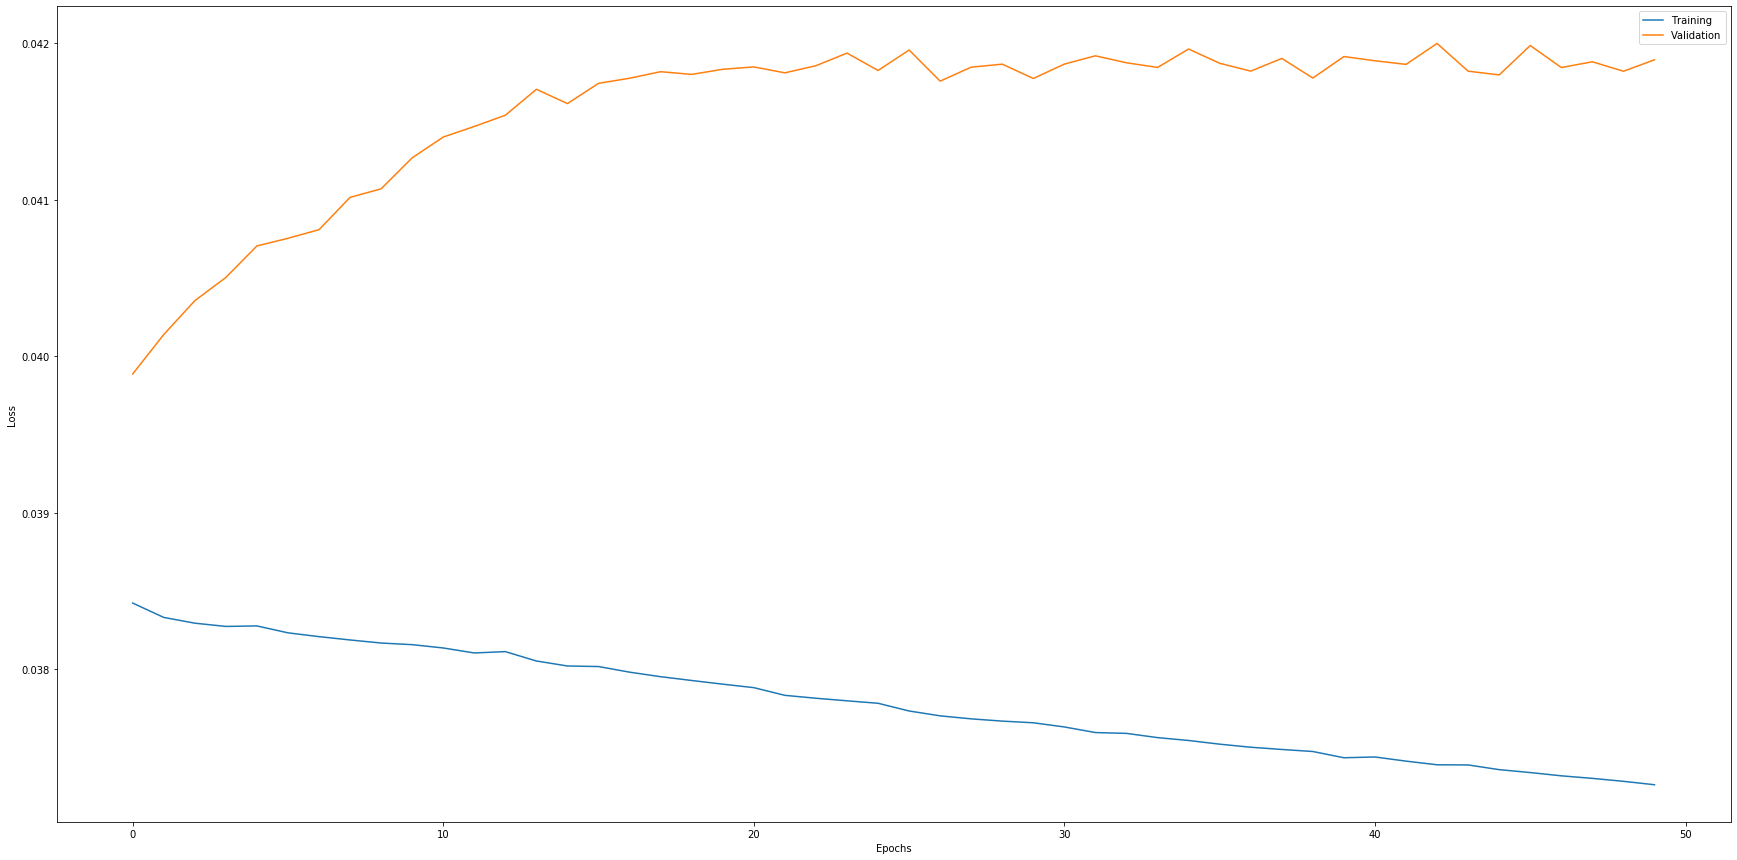

In [22]:
history = regressor.fit(X_train, y_train, epochs=50, batch_size=1024, validation_data=(X_valid, y_valid),
                        verbose=2, shuffle=False)
# plot history

plt.figure(figsize=(30, 15))
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [78]:
# Transform back and plot
y_train_origin = y[:train_size-46]
y_valid_origin = y[train_size:train_size+valid_size]

y_train_pred = regressor.predict(X_train)
y_train_pred_origin = sc_y.inverse_transform(y_train_pred)

y_valid_pred = regressor.predict(X_valid)
y_valid_pred_origin = sc_y.inverse_transform(y_valid_pred)

_y_train_pred_origin = y_train_pred_origin[:, 0:1]
_y_valid_pred_origin = y_valid_pred_origin[:, 0:1]


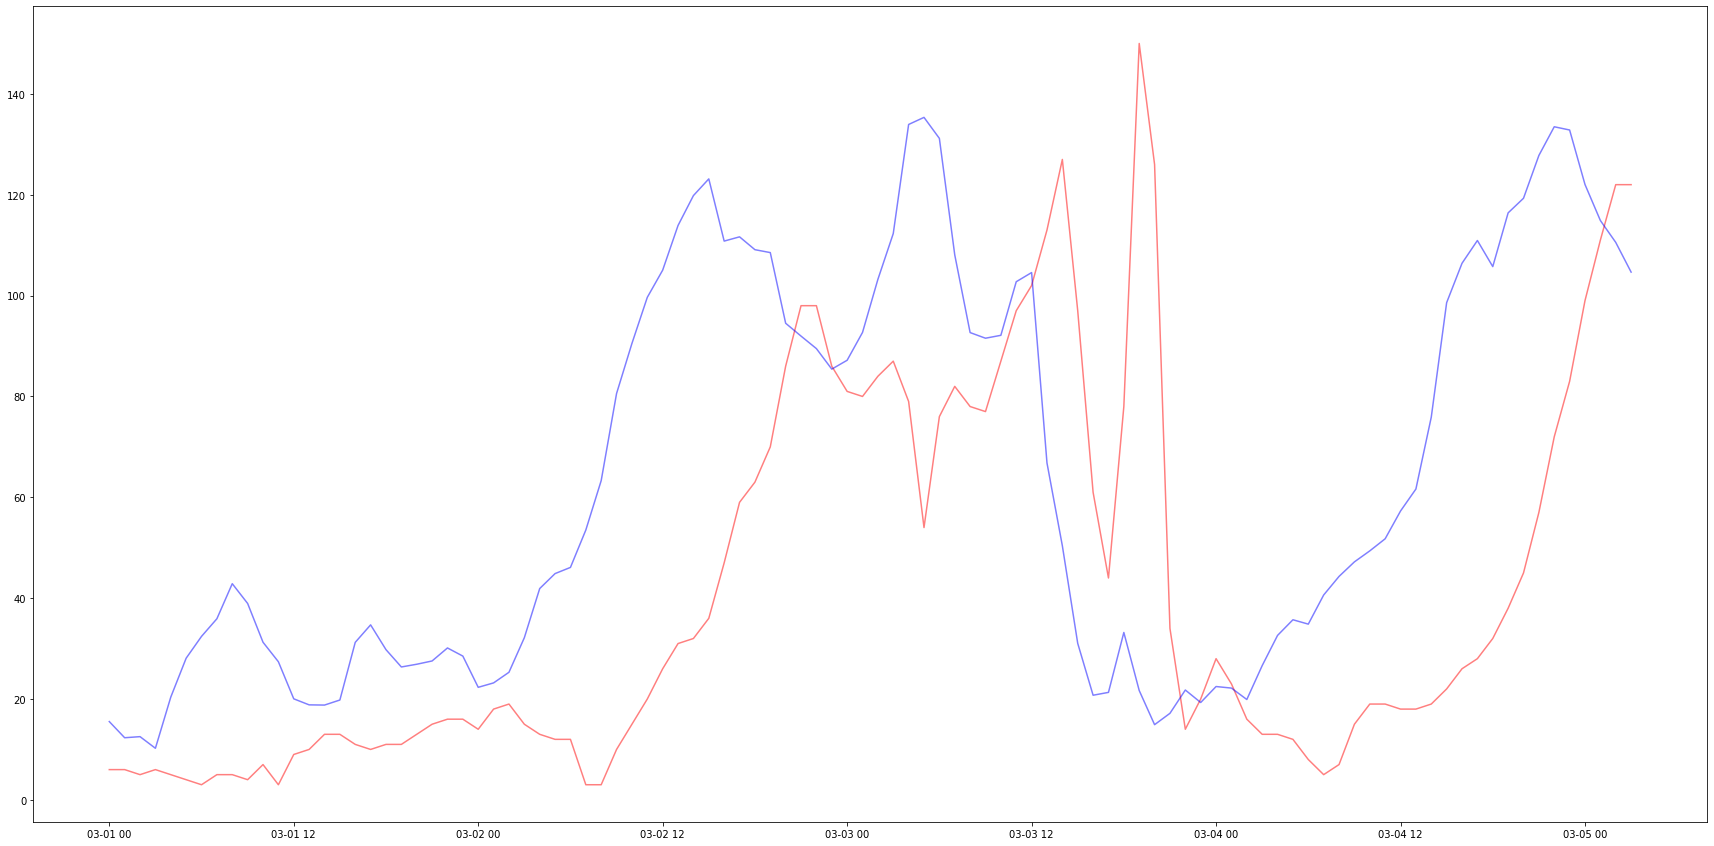

In [84]:
plt.figure(figsize=(30, 15));

plt.plot(pd.to_datetime(dataset[:100].iloc[:, 4].index), dataset[:100].iloc[:, 4], color='red', alpha=0.5, label='Actual PM2.5 Concentration',)
plt.plot(pd.to_datetime(dataset[:100].iloc[:, 4].index), _y_train_pred_origin[:, 0:1][:100], color='blue', alpha=0.5, label='Actual PM2.5 Concentration',)



In [43]:
y_train[:,0].value

AttributeError: 'numpy.ndarray' object has no attribute 'value'